Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 70 rows, 56 columns and 260 nonzeros
Model fingerprint: 0xf3dfd58d
Variable types: 7 continuous, 49 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 70 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 78.339 

Optimal solution found (tolerance 0.00e+00)
Best objective 7.833901044622e+01, best bound 7.833901044622e+01, gap 0.0000%
[0, 2, 1, 4, 6, 5, 3, 0] 
Veh Load:  [120, 10

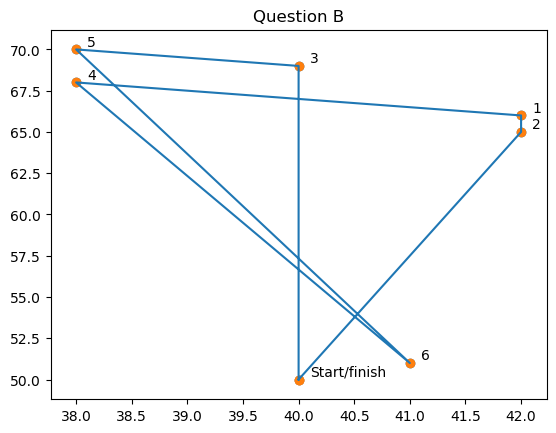

In [23]:
#Import packages
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

#Load the data
data_small = np.loadtxt("data_small.txt", dtype='i')
data_large = np.loadtxt("data_large.txt", dtype='i')


#Problem
model = Model('Assignment_2B')

# Parameters of the model
d = data_small

#Calculate Eucledian distance between the nodes
def c(i,j,data = d):
    distance = np.sqrt((d[i][1] - d[j][1]) ** 2 + (d[i][2] - d[j][2]) ** 2)
    return distance

X_COORD = []
for i in d[:,0]:
    X_COORD.append(d[i][1])
    
Y_COORD = []
for i in d[:,0]:
    Y_COORD.append(d[i][2])
    
D = []
for i in d[:,0]:
    D.append(d[i][3])
    
RT = []
for i in d[:,0]:
    RT.append(d[i][4])
    
DT = []
for i in d[:,0]:
    DT.append(d[i][5])
    
ST = []
for i in d[:,0]:
    ST.append(d[i][6])
    
# Sets

K = range(len(d))
M = 10000

# Variables

x = {}
for i in K:
    for j in K:
        x[i,j] = model.addVar(vtype = GRB.BINARY, name = 'x['+str(i)+','+str(j)+']')
                
t = {}
for i in K:
    t[i] = model.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 't['+str(i)+',]')
    
model.update()

model.setObjective(quicksum(c(i,j) * x[i,j] for i in K for j in K))
model.modelSense = GRB.MINIMIZE
model.update()

# Constraints

# Constraint 1: A vehicle that enters the node should also leave it
con1 = {}
for j in K:
    con1[j] = model.addConstr(quicksum(x[i,j] for i in K) == quicksum(x[j,i] for i in K) )


# Constraint 2: A node should only be visited once
con2 = {}
for j in range(1, len(K)):
    con2[j] = model.addConstr(quicksum(x[i,j] for i in K) == 1)
    
# Constraint 3: A vehicle starts and ends its tour at point 0
con3 = model.addConstr(quicksum(x[0,j] for j in range(1,len(K))) == 1)

#Constraint 4: Implementation of due time
con4 = {}
for i in K:
    con4[i] = model.addConstr(t[i] <= DT[i])
    
# Constraint 5: Imlementation of ready time
con5 = {}
for i in K:
    con5[i] = model.addConstr(t[i] >= RT[i])
    
# Constraint 6: Implementation of service time
con6 = {}
for i in range(1,len(K)):
    for j in K:
        con6[i,j] = model.addConstr(t[i] + ST[i] + c(i,j) - M*(1-x[i,j]) <= t[j])

model.update()

model.setParam('OutputFlag', True) 
model.setParam('MIPGap', 0);        
model.write("output.lp")

model.optimize ()


if model.status == GRB.Status.OPTIMAL:
    
    Loc_visited = []
    Route = []
    Time =[]
    Load  = []
    Route_xcoords = []
    Route_ycoords = []


    for i in K:
        for j in K:
            if x[i,j].x == 1:
                Loc_visited.append(j)

        z = 0
        while (len(Route) < len(Loc_visited)+1):
            for i in K:
                for j in K:
                    if x[i,j].x == 1:
                        if (i in K) & (len(Route)==0):
                            Route.append(i)        
                        if (i == Route[-1]) & (j == Route[0]):
                            Route.append(j)  
                        if (i == Route[-1]) & (j not in Route):
                            Route.append(j)

            z = z + 1
            if z > 500:
                print('Vehicle is not used in this problem')
                break
                
    for w in Route:
        Time.append(int(t[w].x))
    Time[0] = 0
    

    for r in range(len(Route)):
        if r == 0:
            demand_route = 0
            for r in (Route):
                demand_route += D[r]
            Load.append(demand_route)
        else:
            Load.append(Load[r-1] - D[Route[r]])
        
    print(Route,'\nVeh Load: ',Load,'\nTime of Arrival: ', Time)    
    print('Total distance travelled:     %.4f' % model.objVal)

# Plot
    
    origin_x = [X_COORD[0]]
    origin_y = [Y_COORD[0]]
    plt.style.use('default')

    Route_xcoords = [X_COORD[p] for p in Route]
    Route_ycoords = [Y_COORD[p] for p in Route]
    
    for q in K:
        if q == Route[0]:
            plt.annotate('Start/finish',(X_COORD[q], Y_COORD[q]), xytext=(X_COORD[q]+0.1, Y_COORD[q]+0.2))
        else:
            plt.annotate(q ,(X_COORD[q], Y_COORD[q]), xytext=(X_COORD[q]+0.1, Y_COORD[q]+0.2))

    plt.scatter(X_COORD, Y_COORD)
    
    plt.scatter(Route_xcoords, Route_ycoords)
    plt.plot(Route_xcoords, Route_ycoords)
    
    plt.title('Question B')
    plt.show()

else:
    print('\nNo feasible solution found')

NameError: name 'LOC_ID' is not defined